In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt

In [2]:
# waveform function for me to not bang my keyboard
def disp_waveform(signal, sr=None):
    plt.figure(figsize=(7,2))
    return librosa.display.waveshow(signal, sr=sr)


## Data preprocessing for test.wav (test one wav file)

In [ ]:
sample0, sr0 = librosa.load("../wav/Hello World.wav")


/Users/srsys_516/keyboard-sidechannel/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sr0

22050

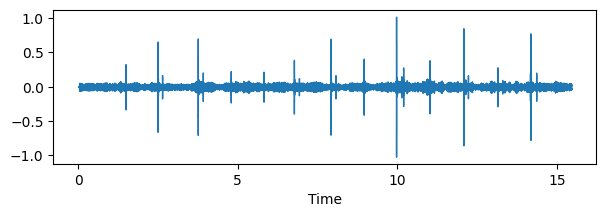

In [5]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(sample0, sr=sr0)

In [6]:
# Unified parameters (run this once)
n_fft = 1024
hop_length = 256
before = 2400
after = 5000

# threshold percentile used inside isolator when threshold=None
threshold_percentile = 96

# 최소 키 누르기 간격 (초 단위) - 동시 타이핑 고려
min_keystroke_gap = 0.03  # 50ms (손가락 2개 겹침 허용), 필요시 0.03~0.1로 조정

# band-limited energy for keystroke detection
band_fmin = 1000
band_fmax = 13000

In [7]:
#Calculating the STFT of the Sample
fft = librosa.stft(sample0, n_fft = n_fft , hop_length = hop_length)

#Calculating the Energy of the Signal using FFT
#energy = np.abs(np.sum(fft, axis=0)).astype(float)
energy = np.sum(np.abs(fft)**2, axis=0)   # power 합 (표준)

In [8]:
len(energy), len(sample0), len(fft)

(1331, 340570, 513)

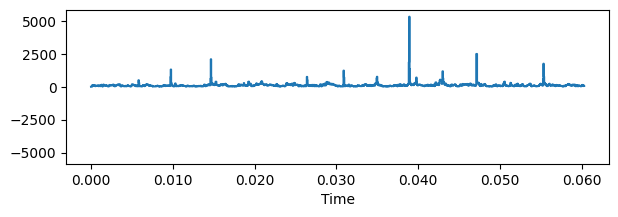

In [9]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(energy)

In [10]:
# Band-limited energy (focus on keystroke band)
fft = librosa.stft(sample0, n_fft=n_fft, hop_length=hop_length)
frequencies = librosa.fft_frequencies(sr=sr0, n_fft=n_fft)
band_mask = (frequencies >= band_fmin) & (frequencies <= band_fmax)
energy = np.sum(np.abs(fft[band_mask])**2, axis=0)

#threshold = 0.9
threshold = np.percentile(energy, threshold_percentile)   # 95~99 사이로 조절
#med = np.median(energy)
#mad = np.median(np.abs(energy - med))
#threshold = med + 6 * mad   # 6~10 범위로 조절

#Converting into Binary
threshed = energy > threshold

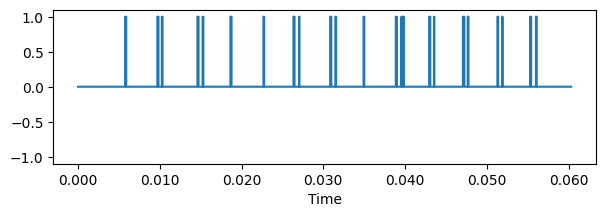

In [11]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(threshed.astype(float))

In [12]:
peaks = np.where(threshed == True)[0]
print(peaks)

[ 127  128  129  214  215  216  226  227  322  323  324  336  337  411
  412  413  500  501  581  582  583  596  680  681  682  694  695  770
  771  857  858  859  872  876  877  878  947  948  949  960 1038 1039
 1040 1041 1051 1052 1131 1132 1144 1219 1220 1221 1235 1236]


In [13]:
peak_count = len(peaks)
print(peak_count)

54


/var/folders/mz/2wl7n1990lv2x93xqyw579x80000gn/T/ipykernel_29204/3848659538.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7, 2))


<Figure size 700x200 with 0 Axes>

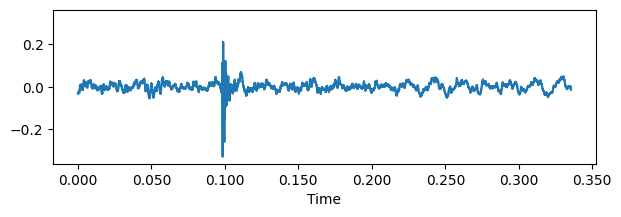

<Figure size 700x200 with 0 Axes>

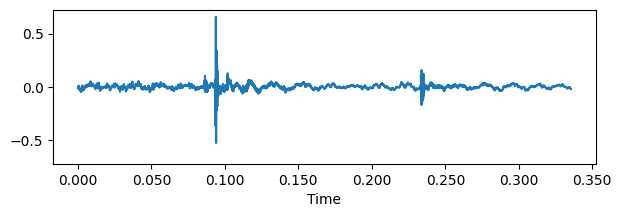

<Figure size 700x200 with 0 Axes>

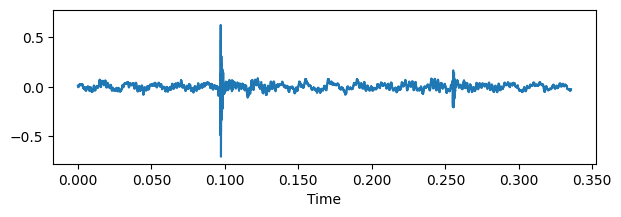

<Figure size 700x200 with 0 Axes>

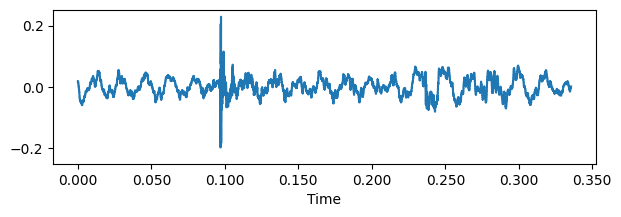

<Figure size 700x200 with 0 Axes>

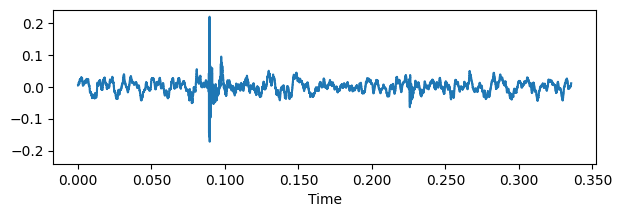

<Figure size 700x200 with 0 Axes>

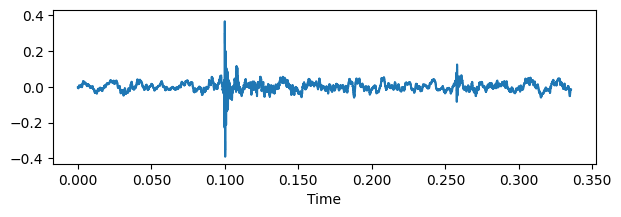

<Figure size 700x200 with 0 Axes>

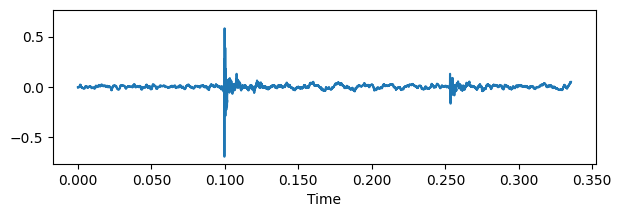

<Figure size 700x200 with 0 Axes>

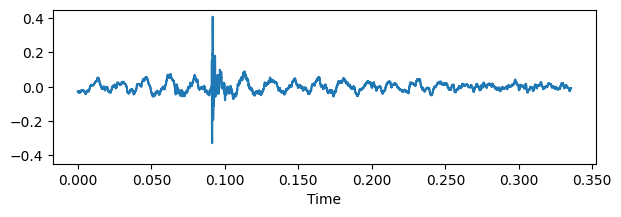

<Figure size 700x200 with 0 Axes>

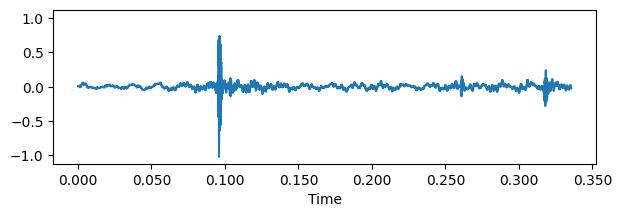

<Figure size 700x200 with 0 Axes>

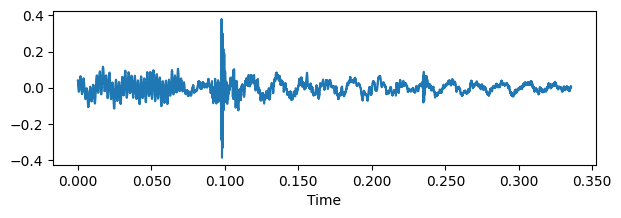

<Figure size 700x200 with 0 Axes>

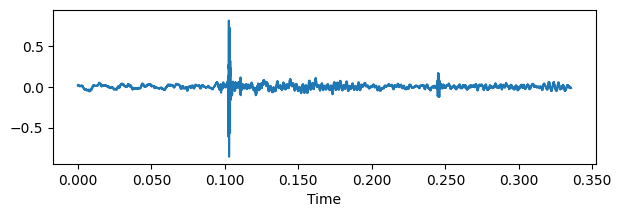

<Figure size 700x200 with 0 Axes>

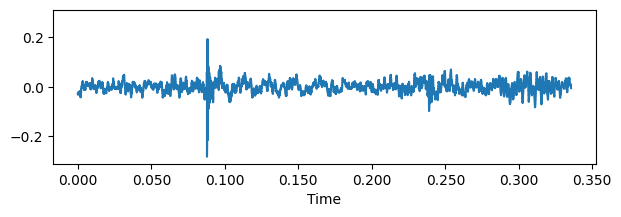

<Figure size 700x200 with 0 Axes>

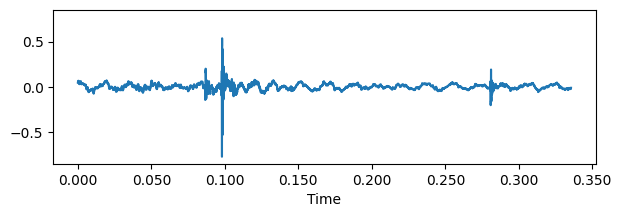

In [14]:
prev_end = sr0*0.1*(-1)
strokes = []
stroke_times = []  # IKI 계산을 위해 타이밍 기록

for i in range(peak_count):
  this_peak = peaks[i]
  timestamp = (this_peak*hop_length) + n_fft//2
  if timestamp > prev_end + (min_keystroke_gap * sr0):
    keystroke = sample0[timestamp-before:timestamp+after]
    strokes.append(torch.tensor(keystroke)[None, :])
    stroke_times.append(timestamp / sr0)  # 초 단위로 타이밍 기록
    plt.figure(figsize=(7, 2))
    disp_waveform(keystroke, sr=sr0)
    prev_end = timestamp+after

In [15]:
print("peaks:", len(peaks))
print("strokes:", len(strokes))

peaks: 54
strokes: 13


In [16]:
iki = np.diff(stroke_times)
print(f"Stroke count: {len(stroke_times)}")
print(f"IKI (초): {iki}")
print(f"IKI (ms): {iki * 1000}")


print("stroke_times:", stroke_times)

if len(stroke_times) < 2:
    print("=> stroke_times가 2개 미만입니다. isolator/peaks 확인 필요.")
else:
    iki = np.diff(np.array(stroke_times))
    
    short_idx = np.where(iki < 0.4)[0]
    

   
    for i in short_idx:
        print(i, stroke_times[i], stroke_times[i+1], iki[i])
        start = int(max(0, (stroke_times[i]-0.1)*sr0))
        end = int(min(len(sample0), (stroke_times[i+1]+0.1)*sr0))
        plt.figure(figsize=(8,2))
        disp_waveform(sample0[start:end], sr=sr0)
        plt.show()

Stroke count: 13
IKI (초): [1.01006803 1.25387755 1.03328798 1.03328798 0.94040816 1.14938776
 1.04489796 1.01006803 1.04489796 1.05650794 1.07972789 1.021678  ]
IKI (ms): [1010.06802721 1253.87755102 1033.28798186 1033.28798186  940.40816327
 1149.3877551  1044.89795918 1010.06802721 1044.89795918 1056.50793651
 1079.72789116 1021.67800454]
stroke_times: [np.float64(1.497687074829932), np.float64(2.507755102040816), np.float64(3.7616326530612243), np.float64(4.794920634920635), np.float64(5.828208616780046), np.float64(6.768616780045352), np.float64(7.918004535147392), np.float64(8.962902494331066), np.float64(9.97297052154195), np.float64(11.017868480725623), np.float64(12.07437641723356), np.float64(13.154104308390023), np.float64(14.17578231292517)]
